# <center>__MÉTODOS NUMÉRICOS__</center>
## <center>__PROJETO DA UNIDADE 2__</center>

#### <center>__ALUNO:__</center>

<div class="alert alert-block alert-info">
1. INTRODUÇÃO
</div>

Nesse relatório irei analisar um notebook de remoção de fundo de imagens com PCA Robusto. Essa técnica é muito importante atualmente para analise de imagens em várias áreas (e para remover objetos indesejados de uma foto muito bonita que você nunca vai tirar igual).

Notas:
Tive vários problemas ao executar o notebook pois algumas bibliotecas que ele usava estavam muito desatualizadas e por isso precisei fazer alguns ajustes que estão listados abaixo:
- Precisei atualizar as seguintes bibliotecas:
```
pip3 install scipy==1.7.2

pip3 install pillow==9.0.1

pip3 install moviepy==1.0.3

pip3 install ipython==8.1.1
```
- Os links dos vídeos estavam quebrados então precisei baixar direto do notebook.
- Também refatorei alguns métodos por conta da quebra de contratos com as bibliotecas citadas acima, mas mostrarei isso no decorrer do relatório.

<div class="alert alert-block alert-info">
2. DESCRIÇÃO DO PROBLEMA
</div>

Conseguimos resolver inumeros problemas usando SVD, e a limpeza de imagens/vídeos é um deles. O nosso problema é básicamente remover ruidos de um conjunto de imagens, e tentar manter a integridade dessas imagens a ponto que possamos reconhecer a nova imagem quando comparada com a original.
Atualmente existem outros métodos mais sofisticados e complexos que o SVD para realizar essa tarefa, mas mesmo assim o SVD se mostrou muito bom nesse estudo, removendo muito bem algumas pessoas do vídeo disponibilizado no notebook.
É importante salientar que trabalhei apenas com os quadros do vídeo, e não com seu áudio. Para isso, quebrei o vídeo em quadros e executei os processos em cada quadro de forma iterativa.

<div class="alert alert-block alert-info">
3. MÉTODOS APLICADOS À SOLUÇÃO
</div>

### SVD
A decomposição de valores singulares de uma matriz é uma maneira de diagonizar a sua matriz e esse método pode ser utilizado para **quaisquer** matrizes (sendo quadradas ou não). É uma forma de "fatorar" a matriz em outros elementos com caracteristicas únicas.
Formulá:
- $M=U\Sigma V^*$
- U = Mátriz Unitária
- $\Sigma$ = matriz diagonal do tamanho de M com números reais não negativos.
- $V^*$ = Vatriz unitária transposta conjugada de V

Para essa aplicação, o SVD é usado junto com a _aproximação de baixo posto_ (low rank).
![Explicação sobre SVD](https://raw.githubusercontent.com/arthur-mts/metodos-numericos/master/projeto/Projeto%20B/data/2022-03-14_21-47.png)
Como podemos ver no recorte acima, cada componente gerado pelo SVD tem a sua caracteristica referente ao conceito da matriz orignal.

### Aproximação de baixo posto
A aproximação de baixo posto é um problema de optimização matemática.
Na matemática, um problema de otimização consiste em selecionar o melhor elemento de um conjunto a partir de um determinado critério.
No low rank, tentamos otimizar a nossa matriz A de rank K para conseguirmos matrizes de colunas e linhas que, quando multiplicadas, nos da uma matriz B que é tão proxima quanto desejado da matriz A original.
$B\approx AX$
$B\approx A(A^t A)^{-1}A^t B$

Nesse contexto, o SVD cai como uma luva nos mostrando os melhores candidatos as matrizes A e B, além do vetor singular da matriz $\Sigma$, nos dando uma matriz aproximada B com o mesmo rank K da matriz A.
Seguem os vídeos de referência para o estudo da Aproximação de baixo posto:
[Link1](https://www.youtube.com/watch?v=12K5aydB9cQ)
[Link2](https://www.youtube.com/watch?v=c7e-D2tmRE0)

<div class="alert alert-block alert-info">
4. IMPLEMENTAÇÃO
</div>

Primeiro, iremos processar o vídeo de exemplo do notebook e extrair os frames.

In [1]:
import moviepy.editor as mpe
from IPython.display import display
from glob import glob
import numpy as np
import scipy.misc
import scipy.ndimage
import os
import scipy
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.request import urlopen
TOL = 1.0e-8

In [2]:
video = mpe.VideoFileClip("/home/arthur/workspace/ifpb/metodos-numericos/projeto/Projeto B/data/download.mp4")

Esse método transforma um frame do vídeo passado em um frame de tons cinzas, o que facilitara na nossa analise.

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
def create_data_matrix_from_video(clip, fps=5, scale=50):
    res = []
    new_width = int(clip.size[0] * (scale/100))
    new_heigth = int(clip.size[1] * (scale/100))
    for i in range(fps * int(clip.duration)):
        gray_frame = rgb2gray(clip.get_frame(i / float(fps)))
        resized_frame = Image.fromarray(gray_frame).resize((new_width,new_heigth),resample=Image.NEAREST)
        res.append(np.array(resized_frame).flatten())

    return np.vstack(res).T

Esse método cria um array de matrizes a partir de um vídeo, recebendo como parametro os frames que serao extraidos por segundo e a escala.
Estou usando a biblioteca pillow pois os métodos do notebook original foram deprecados.

In [5]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f


def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

Método utilitario para plotar todas as imagens de uma lista.

<div class="alert alert-block alert-info">
5. CASOS DE USO
</div>

Primeiramente irei rodar o projeto com o vídeo disponibilizado no notebook.

In [6]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [7]:
M = create_data_matrix_from_video(video, 100, scale)

Vamos mostrar um quadro para ver se esta tudo certo:

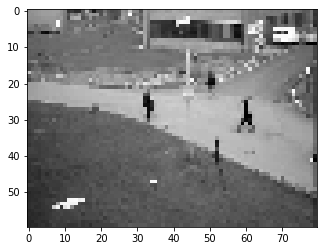

In [8]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Também vamos salvar a matriz M para evitar ter que recomputar os dados.

In [9]:
np.save("low_res_surveillance_matrix.npy", M)

Primeiramente iremos usar o método randomized_svd da biblioteca decomposition para calcular os valores do SVD e com isso o low_rank da matriz.

Vamos tentar com rank 2. Dependendo da esacla em que criamos a matriz M, pode demorar bastante...

In [10]:
from sklearn import decomposition

In [11]:
u, s, v = decomposition.randomized_svd(M, 2)

In [12]:
low_rank = u @ np.diag(s) @ v

In [13]:
low_rank.shape

(4800, 5000)

In [14]:
M.shape

(4800, 5000)

Imagem gerada pelo low rank do SVD, com os objetos removidos (pessoas). O SVD consegue identificar similaridades na matriz e assim gerar uma matriz sem esses ruidos.

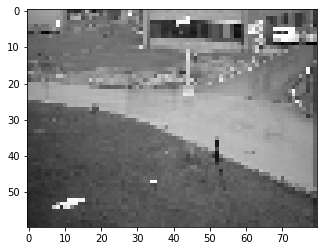

In [15]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray')

Para removermos o fundo da imagem, basta subtrair a matriz de quadros orignal (M) pelo o resultado alcançado do low_rank, com isso restarão os quadros que foram removidos pelo SVD já que as duas matrizes tem as mesmas dimensões e ela não ficará distorcida.

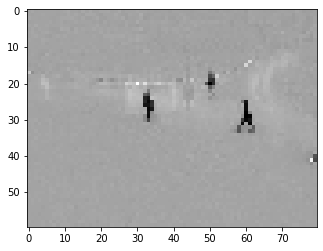

In [16]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray')

Vamos tentar o mesmo processo, agora com o rank 1:

In [17]:
u, s, v = decomposition.randomized_svd(M, 1)
low_rank = u @ np.diag(s) @ v

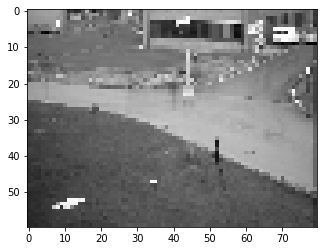

In [18]:
plt.imshow(np.reshape(low_rank[:,111], dims), cmap='gray')

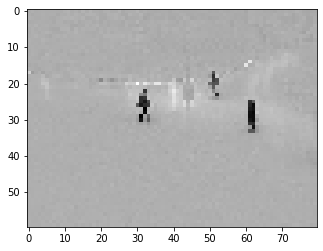

In [19]:
plt.imshow(np.reshape(M[:,111] - low_rank[:,111], dims), cmap='gray');

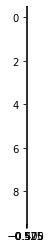

In [20]:
plt.imshow(np.reshape(M[:, 111] - low_rank[:, 111], dims)[50:150, 100:270], cmap='gray');

Zoom para visualizzarmos melhor os resultados:

Agora vamos executar com o Robust PCA, porém com apenas 1 repetição.

In [21]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca
TOL=1e-9
MAX_ITERS=3
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)
def norm_op(M): return _svd(M, 1)[1][0]
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape

    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5

    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1

    examples = []

    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu

        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)

        # update estimate }of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)

        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))

        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho

        examples.extend([S[140,:], L[140,:]])

        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break

    if trans: L=L.T; S=S.T
    return L, S, examples

In [22]:
m, n = M.shape
round(m * .05)

240

In [23]:
L, S, examples =  pcp(M, maxiter=3, k=10)

rank sv: 1
error:  0.14960253833268183
rank sv: 241
error:  0.044465964128957
rank sv: 43
error:  0.005643110870383611


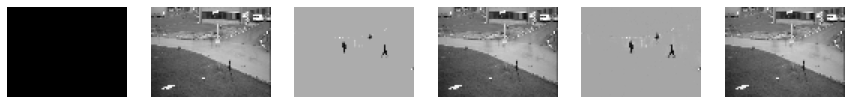

In [26]:
plots(examples, dims, rows=1)

Agora uma imagem minha:

In [27]:
img = Image.open("/home/arthur/workspace/ifpb/metodos-numericos/projeto/Projeto B/data/luke.jpg")

In [31]:
gray_img = rgb2gray(np.asarray(img))

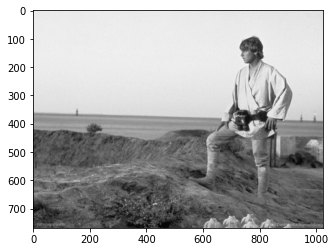

In [33]:
plt.imshow(gray_img, cmap='gray')

In [34]:
u, s, v = decomposition.randomized_svd(gray_img, 2)
low_rank = u @ np.diag(s) @ v

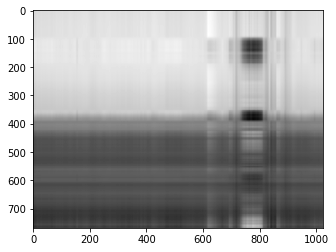

In [35]:
plt.imshow(low_rank, cmap='gray');

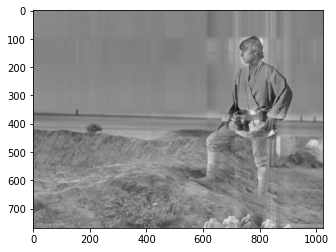

In [36]:
plt.imshow(gray_img-low_rank, cmap='gray');

Podemos ver que não funcionou muito bem.

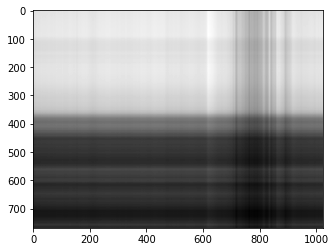

In [37]:
u, s, v = decomposition.randomized_svd(gray_img, 1)
low_rank = u @ np.diag(s) @ v
plt.imshow(low_rank, cmap='gray');

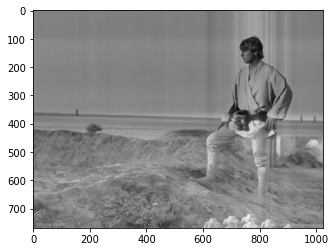

In [38]:
plt.imshow(gray_img-low_rank, cmap='gray');

In [39]:
L, S, examples = pcp(gray_img, maxiter=3, k=10)

rank sv: 1
error:  0.17509943068957473
rank sv: 39
error:  0.03881228239605243
rank sv: 34
error:  0.0051774359805143565


In [42]:
gray_img.shape

(768, 1024)

ValueError: cannot reshape array of size 768 into shape (60,80)

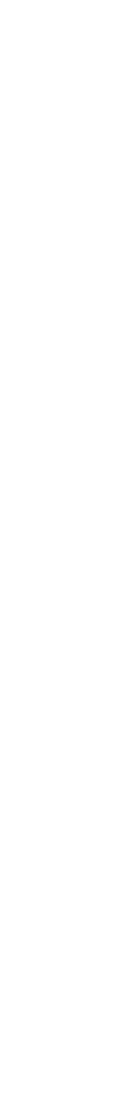

In [47]:
plots(examples, dims, rows=1)